Aquest codi llegeix els fitxers amb les dades de les estadístiques dels jugadors i en treu les classificacions.

In [1]:
import asyncio
import sys

if sys.platform.startswith('win'):
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

In [2]:
#!pip install numpy==1.25.2
#!pip uninstall xarray scipy netCDF4
#!pip install xarray scipy netCDF4
#!pip install pybin11 --upgrade

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [4]:
#Extraiem el dia d'avui
from datetime import datetime
today = datetime.today().strftime('%d/%m/%Y')

In [5]:
# Definim tab20 com la paleta per defecte dels plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

In [6]:
# Llegim les dades
dataarray = xr.open_dataset('stats.nc', engine='scipy')
dataarray

<xarray.Dataset> Size: 137kB
Dimensions:                (matchday: 46, player: 20)
Coordinates:
  * matchday               (matchday) int32 184B 0 1 2 3 4 5 ... 41 42 43 44 45
  * player                 (player) object 160B 'Alejandro' 'Antía' ... 'Víctor'
Data variables: (12/23)
    GamesPlayed            (matchday, player) int32 4kB ...
    PlayedAttack           (matchday, player) int32 4kB ...
    PlayedDefense          (matchday, player) int32 4kB ...
    WinPlayed              (matchday, player) float64 7kB ...
    WinPlayedAttack        (matchday, player) float64 7kB ...
    WinPlayedDefense       (matchday, player) float64 7kB ...
    ...                     ...
    ReceivedDefensePlayed  (matchday, player) float64 7kB ...
    ELOAttack              (matchday, player) float64 7kB ...
    ELODefense             (matchday, player) float64 7kB ...
    AttackIndex            (matchday, player) float64 7kB ...
    DefenseIndex           (matchday, player) float64 7kB ...
    WeightedELO            (matchday, player) float64 7kB ...

In [7]:
# Filtrem els jugadors que han jugat menys partits

# Create a dataaray with the coordinates of the dimension to remove ('player')
last_games_played = dataarray['GamesPlayed'].isel(matchday=-1) # list of the number of games played by each player
minimum_games = last_games_played.max()* 0.2 # minimum of 20% of the plyer that has played the most matches
mask = xr.DataArray(last_games_played > minimum_games, dims = 'player', coords = {'player':dataarray.player})

# Filter out players
dataarray = dataarray.where(mask, drop=True)

In [8]:
# Extreiem els noms dels jugadors i les jornades
players_names = dataarray['player'].astype(str).values # noms dels jugadors
matchdays = dataarray['matchday'] # array de números de jornades

In [9]:
# Extreiem els valors de victòries / jugats de l'última jornada
winplayed_values = dataarray['WinPlayed'].isel(matchday = -1).values

# Ordenem de major a menor
winplayed_sorted_idx = np.argsort(winplayed_values)[::-1] # índexs d'ordre (revertim per fer de major a menor)
winplayed_sorted = winplayed_values[winplayed_sorted_idx] # ordenem
winplayed_sorted = np.round(winplayed_sorted, 2) # arrondonim els valors a 2 xifres decimals

players_names_sorted = players_names[winplayed_sorted_idx] # ordenem els noms dels jugadors

#Posem els resultats a una taula (DataFrame)
winplayed_stats = pd.DataFrame(np.array([players_names_sorted, winplayed_sorted]).T, index = np.arange(1, players_names_sorted.shape[0]+1))
caption = "Games won / Games played (Matchday %.1d)" % (matchdays[-1])
winplayed_stats = winplayed_stats.style.set_caption(caption) # afegim títol al dataframe

# Guardem la taula en HTML per mostrar-la al README
winplayed_stats.to_html('results/winplayed_stats.html')

winplayed_stats

,0,1
1,Víctor,0.64
2,Antía,0.59
3,Dani,0.59
4,Pau,0.56
5,Maider,0.49
6,Luis,0.46
7,Guille,0.42
8,Jose,0.4
9,Pedro,0.29


### Gràfic

Fem un gràfic de l'evolució dels paràmetres durant les jornades

In [10]:
def plot_matchday_evolution(parameter, title, ax, label=False):
    #Extract parameter values
    parameter_values = dataarray[parameter]
    
    for player in players_names: #for each player
        parameter_evolution = parameter_values.sel(player=player) # extract player data
        parameter_evolution_values = parameter_evolution.values # extract player data values

        if ("ELO" in parameter) and (parameter != 'WeightedELO'): # si hi ha un 0 (a WeightedELO), subtituir per 1000 (el valor de referència)
            parameter_evolution_values = np.where(parameter_evolution_values == 0, 1000, parameter_evolution_values)
        
        if label:
            ax.plot(matchdays, parameter_evolution_values, marker = 'o', label=player) #plot
        else:
            ax.plot(matchdays, parameter_evolution_values, marker = 'o') #plot sense label

        # Add player label
        #ax.text(matchdays[-1]+1, parameter_evolution_values[-1], player, ha='left', va='center')

        # Add title
        ax.set_title(title, fontsize=10)
        

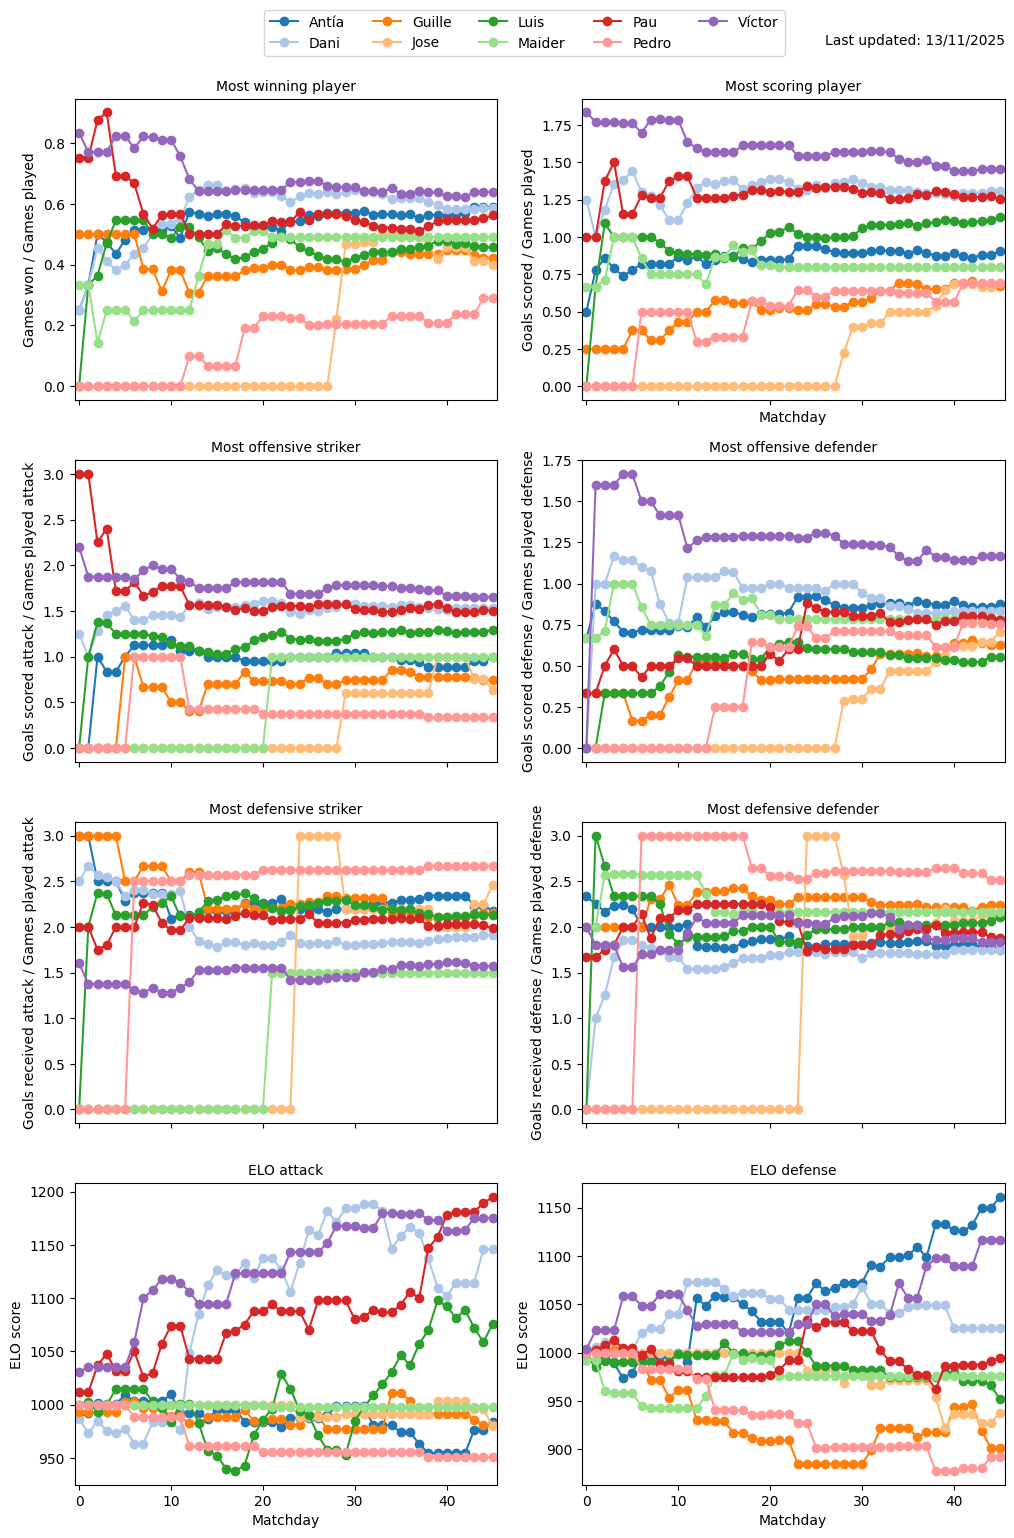

In [11]:
# Initialize figure
fig, axs = plt.subplots(figsize=(12, 18), ncols= 2, nrows = 4, sharex=True)
axs = axs.flatten()

plot_matchday_evolution('WinPlayed', "Most winning player", axs[0], label = True)
plot_matchday_evolution('ScoredPlayed', "Most scoring player", axs[1])
plot_matchday_evolution('ScoredAttackPlayed', "Most offensive striker", axs[2])
plot_matchday_evolution('ScoredDefensePlayed', "Most offensive defender", axs[3])
plot_matchday_evolution('ReceivedAttackPlayed', "Most defensive striker", axs[4])
plot_matchday_evolution('ReceivedDefensePlayed', "Most defensive defender", axs[5])
plot_matchday_evolution('ELOAttack', "ELO attack", axs[6])
plot_matchday_evolution('ELODefense', "ELO defense", axs[7])

axs[1].set_xlabel("Matchday")
axs[0].set_ylabel("Games won / Games played")
axs[1].set_ylabel("Goals scored / Games played")
axs[2].set_ylabel("Goals scored attack / Games played attack")
axs[3].set_ylabel("Goals scored defense / Games played defense")
axs[4].set_ylabel("Goals received attack / Games played attack")
axs[5].set_ylabel("Goals received defense / Games played defense")
axs[6].set_ylabel("ELO score")
axs[7].set_ylabel("ELO score")

for i in range(len(axs)):
    axs[i].set_xlim(-0.5, matchdays[-1]+0.5)

for i in [-1, -2]:
    axs[i].set_xlabel('Matchday')

fig.legend(bbox_to_anchor = ( 0.5, 0.9), ncol = 5, loc = 'lower center')

# Afegim l'etiqueta del dia d'avui
fig.text(0.75, 0.91, f"Last updated: {today}", transform=fig.transFigure)

# Guardem la figura per poderla posar al README
plt.subplots_adjust(hspace=0.2)
plt.savefig('results/winplayed_stats.png', dpi=300, bbox_inches='tight')

### Plot ELO

In [12]:
# Funció que fa una classifiació d'un paràmetre
from pandas.plotting import table

def plot_standings_table(parameter, title, ax):
    # Extreiem els valors de victòries / jugats de l'última jornada
    parameter_values = dataarray[parameter].isel(matchday = -1).values
    
    # Ordenem de major a menor
    parameter_sorted_idx = np.argsort(parameter_values)[::-1] # índexs d'ordre (revertim per fer de major a menor)

    players_names_sorted = players_names[parameter_sorted_idx] # ordenem els noms dels jugadors
    
    #Posem els resultats a una taula (DataFrame)
    standings_table = pd.DataFrame(np.array([np.arange(1, players_names_sorted.shape[0]+1), players_names_sorted]).T, columns=['', title])
    
    table_plt = ax.table(cellText=standings_table.values, colLabels=standings_table.columns, loc='right', cellLoc='left')

    # Calculate the number of rows (data + header)
    n_rows = len(players_names_sorted) +1  # +1 for column labels

    # Adjust cell heights to fill the axes
    col_widths = [0.05, 0.2]
    row_height = 1.0 / n_rows  # normalized coordinates
    for (row, col), cell in table_plt.get_celld().items():
        cell.set_height(row_height)
        cell.set_width(col_widths[col])
    

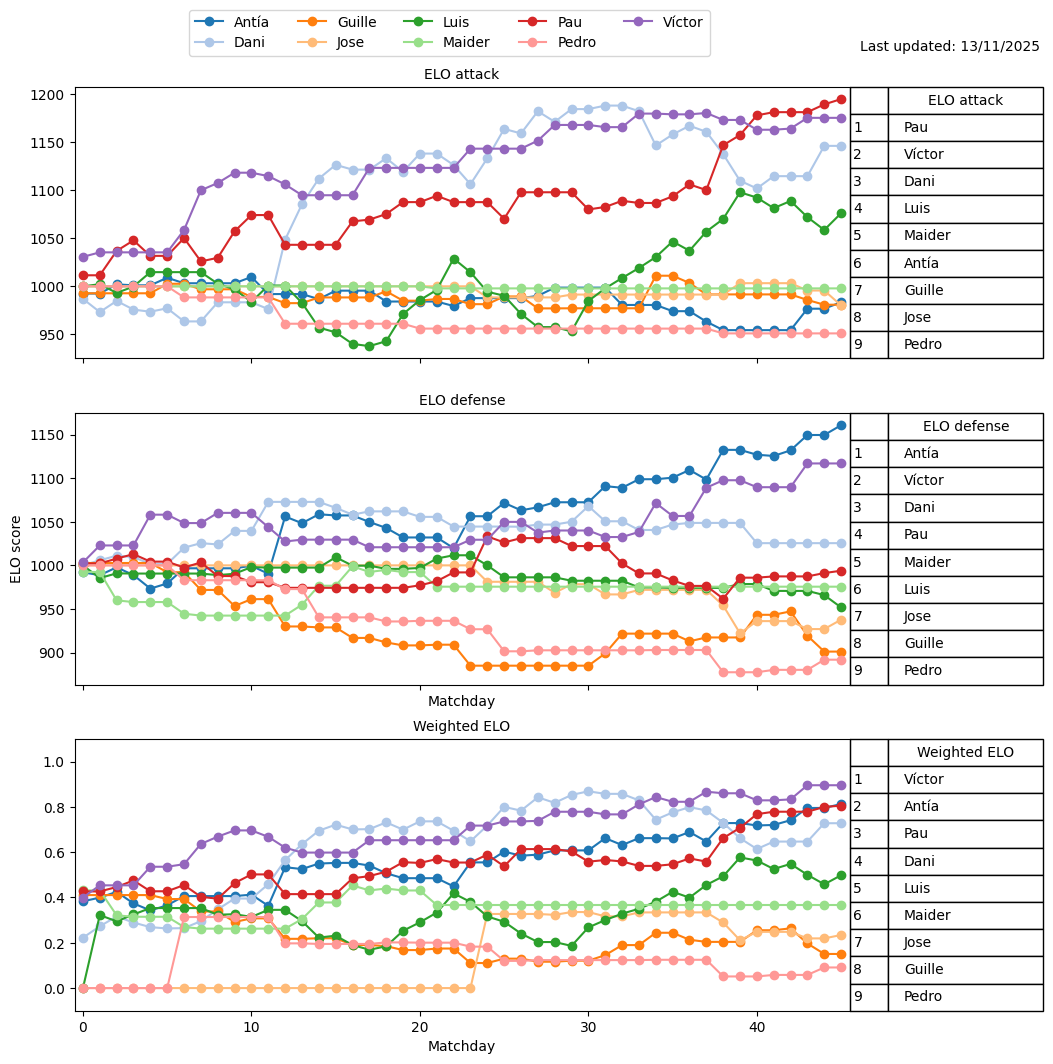

In [13]:
# Initialize figure
fig, axs = plt.subplots(figsize=(10, 12), ncols= 1, nrows = 3, sharex=True)
axs = axs.flatten()

plot_matchday_evolution('ELOAttack', "ELO attack", axs[0], label=True)
plot_matchday_evolution('ELODefense', "ELO defense", axs[1])
plot_matchday_evolution('WeightedELO', "Weighted ELO", axs[2])

plot_standings_table('ELOAttack', 'ELO attack', axs[0])
plot_standings_table('ELODefense', 'ELO defense', axs[1])
plot_standings_table('WeightedELO', 'Weighted ELO', axs[2])

axs[1].set_ylabel("ELO score")

for i in range(len(axs)):
    axs[i].set_xlim(-0.5, matchdays[-1]+0.5)

for i in [-1, -2]:
    axs[i].set_xlabel('Matchday')

# Llegenda
fig.legend(bbox_to_anchor = ( 0.5, 0.9), ncol = 5, loc = 'lower center')

# y lim for Weighted ELO
axs[2].set_ylim(-0.1, 1.1)

# Afegim l'etiqueta del dia d'avui
fig.text(0.91, 0.91, f"Last updated: {today}", transform=fig.transFigure)

# Guardem la figura per poderla posar al README
plt.subplots_adjust(hspace=0.2)
plt.savefig('results/ELO_stats.png', dpi=300, bbox_inches='tight')

# Scatter plots

Aquests gràfics en permeten comparar paràmetres de jugadors directament els uns amb els altres.

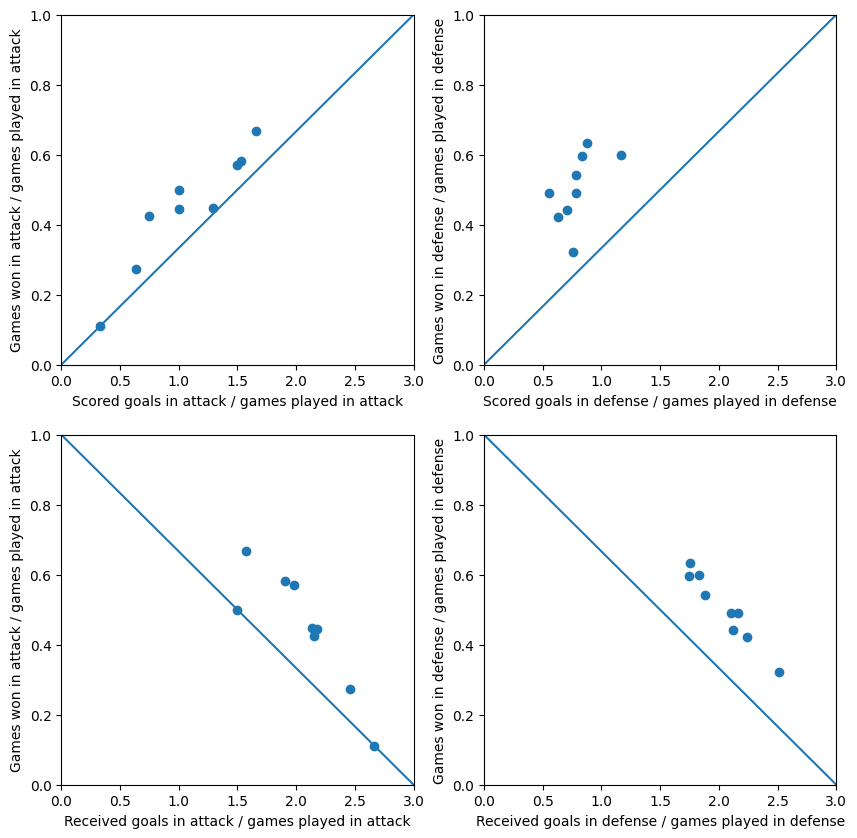

<Figure size 640x480 with 0 Axes>

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
axs = axs.flatten()

# Gràfic de gols atacans/partit i gols equip/partit per veure quin jugador contribueix més a l'atac de l'equip. Com menys gols marqui però més alt sigui el % de victòries vol dir que l'atacant depèn molt dels gols del defensor. La línia recta és la relació 1:3
axs[0].scatter(dataarray.ScoredAttackPlayed.isel(matchday=-1), dataarray.WinPlayedAttack.isel(matchday=-1))
axs[0].set_xlabel("Scored goals in attack / games played in attack")
axs[0].set_ylabel("Games won in attack / games played in attack")

axs[1].scatter(dataarray.ScoredDefensePlayed.isel(matchday=-1), dataarray.WinPlayedDefense.isel(matchday=-1))
axs[1].set_xlabel("Scored goals in defense / games played in defense")
axs[1].set_ylabel("Games won in defense / games played in defense")


axs[2].scatter(dataarray.ReceivedAttackPlayed.isel(matchday=-1), dataarray.WinPlayedAttack.isel(matchday=-1))
axs[2].set_xlabel("Received goals in attack / games played in attack")
axs[2].set_ylabel("Games won in attack / games played in attack")

axs[3].scatter(dataarray.ReceivedDefensePlayed.isel(matchday=-1), dataarray.WinPlayedDefense.isel(matchday=-1))
axs[3].set_xlabel("Received goals in defense / games played in defense")
axs[3].set_ylabel("Games won in defense / games played in defense")

for i in range(4):
    axs[i].set_xlim(0, 3)
    axs[i].set_ylim(0, 1)
    if i == 0 or i == 1:
        axs[i].plot([0, 3], [0,1])
    else:
        axs[i].plot([3, 0], [0, 1])

plt.show()
plt.savefig("results/scatter_plots.png", dpi=300, bbox_inches='tight')

In [15]:
dataarray

<xarray.Dataset> Size: 76kB
Dimensions:                (matchday: 46, player: 9)
Coordinates:
  * matchday               (matchday) int32 184B 0 1 2 3 4 5 ... 41 42 43 44 45
  * player                 (player) object 72B 'Antía' 'Dani' ... 'Víctor'
Data variables: (12/23)
    GamesPlayed            (matchday, player) float64 3kB 4.0 4.0 ... 62.0 144.0
    PlayedAttack           (matchday, player) float64 3kB 1.0 4.0 ... 9.0 84.0
    PlayedDefense          (matchday, player) float64 3kB 3.0 0.0 ... 53.0 60.0
    WinPlayed              (matchday, player) float64 3kB 0.25 0.25 ... 0.6389
    WinPlayedAttack        (matchday, player) float64 3kB 0.0 0.25 ... 0.6667
    WinPlayedDefense       (matchday, player) float64 3kB 0.3333 0.0 ... 0.6
    ...                     ...
    ReceivedDefensePlayed  (matchday, player) float64 3kB 2.333 0.0 ... 1.833
    ELOAttack              (matchday, player) float64 3kB 992.5 ... 1.175e+03
    ELODefense             (matchday, player) float64 3kB 992.0 ... 1.117e+03
    AttackIndex            (matchday, player) float64 3kB 1.5 5.0 ... 110.2
    DefenseIndex           (matchday, player) float64 3kB 2.25 10.0 ... 106.2
    WeightedELO            (matchday, player) float64 3kB 0.3832 ... 0.8956

In [16]:
dataarray.close()